# Test des outils d'OCR python

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatch
import itertools

import IPython.display as disp
from PIL import Image
import pyocr
import pytesseract

/var/lib/anaconda3/envs/py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Définition des données d'entrées

On liste les fichiers qui sont positionnés en entrée. Ils doivent tous être dans le répertoire *data/* (mais il est possible d'ajuster ce paramètre).

In [2]:
# file list 
# MUST be in data/ folder
path_to_files = os.path.join('data')

files = [
         'FT-91684_Fd volaille nat brq 1L Chef_Nestle-1.png', 
         'FT-91684_Fd volaille nat brq 1L Chef_Nestle-2.png', 
         'Fiche nestlé Docello.PNG'
        ]

## Définition des configurations d'outils

Les outils peuvent avoir des options différentes, avec un impact sur la performance de la reconnaissance.
On liste les différentes configurations que l'on souhaite tester.

In [3]:
# list of tools to compare
tools = [
            {
                'name': 'pyocr - Tesseract (sh) - Text',
                'wrapper': 'pyocr', 
                'tool_order': 0, 
                'builder': pyocr.builders.TextBuilder(),
                'kind': 'text'
            },
            {
                'name': 'pyocr - Tesseract (sh) - WordBox',
                'wrapper': 'pyocr', 
                'tool_order': 0, 
                'builder': pyocr.builders.WordBoxBuilder(),
                'kind': 'wordbox'
            }, 
            {
                'name': 'pyocr - Tesseract (sh) - LineBox',
                'wrapper': 'pyocr', 
                'tool_order': 0, 
                'builder': pyocr.builders.LineBoxBuilder(),            
                'kind': 'linebox'
            },
            {
                'name': 'pyocr - Tesseract (C-API) - Text',
                'wrapper': 'pyocr', 
                'tool_order': 1, 
                'builder': pyocr.builders.TextBuilder(),
                'kind': 'text'
            },
            {
                'name': 'pyocr - Tesseract (C-API) - WordBox',
                'wrapper': 'pyocr', 
                'tool_order': 1, 
                'builder': pyocr.builders.WordBoxBuilder(),
                'kind': 'wordbox'
            }, 
            {
                'name': 'pyocr - Tesseract (C-API) - LineBox',
                'wrapper': 'pyocr', 
                'tool_order': 1, 
                'builder': pyocr.builders.LineBoxBuilder(),     
                'kind': 'linebox'
            },       
        ]

## Fonctions auxiliaires

### Retravail des coordonnées

Les coordonnées issues des outils d'OCR (à minima pyocr) sont de la forme ( ( x haut gauche , y haut gauche ) , ( x bas droit , y bas droit ) ).

Les rectangles à tracer via matplotlib attendent un format différent : ( ( x haut gauche , y haut gauche ) , largeur, hauteur ).

La fonction ci-dessous effectue le changement de format.

In [4]:
def to_rect_coord(box_position):
    x = box_position[0][0]
    y = box_position[0][1]
    width = box_position[1][0] - x
    height = box_position[1][1] - y
    return(((x, y), width, height))

Je veux : 
- pouvoir lancer de manière unitaire une configuration d'outil sur un fichier donné
- pouvoir filtrer les reconnaissances qui sont perraves
- pouvoir lancer sur une sélection de fichiers une sélection d'outils pour comparer la perf
- pouvoir choisir le format (surlignage rouge, ou cadres + textes)
- tester un coup la possibilité de refaire tourner sur juste une sous partie de l'image
- à terme, pouvoir contrôler la précision de la reconnaissance
...

Donc il pourrait me falloir : 
- une classe qui permet d'instancier une configuration d'outil, et qui permet : 
- de lancer l'OCR, et de récupérer le résultat
- si on lui passe un axes et un fichier, d'aller écrire sur l'axes le format qui va bien avé le fichier
- le filtre... il dépend clairement de l'outil. 

## Premier test basique

### Fichier original

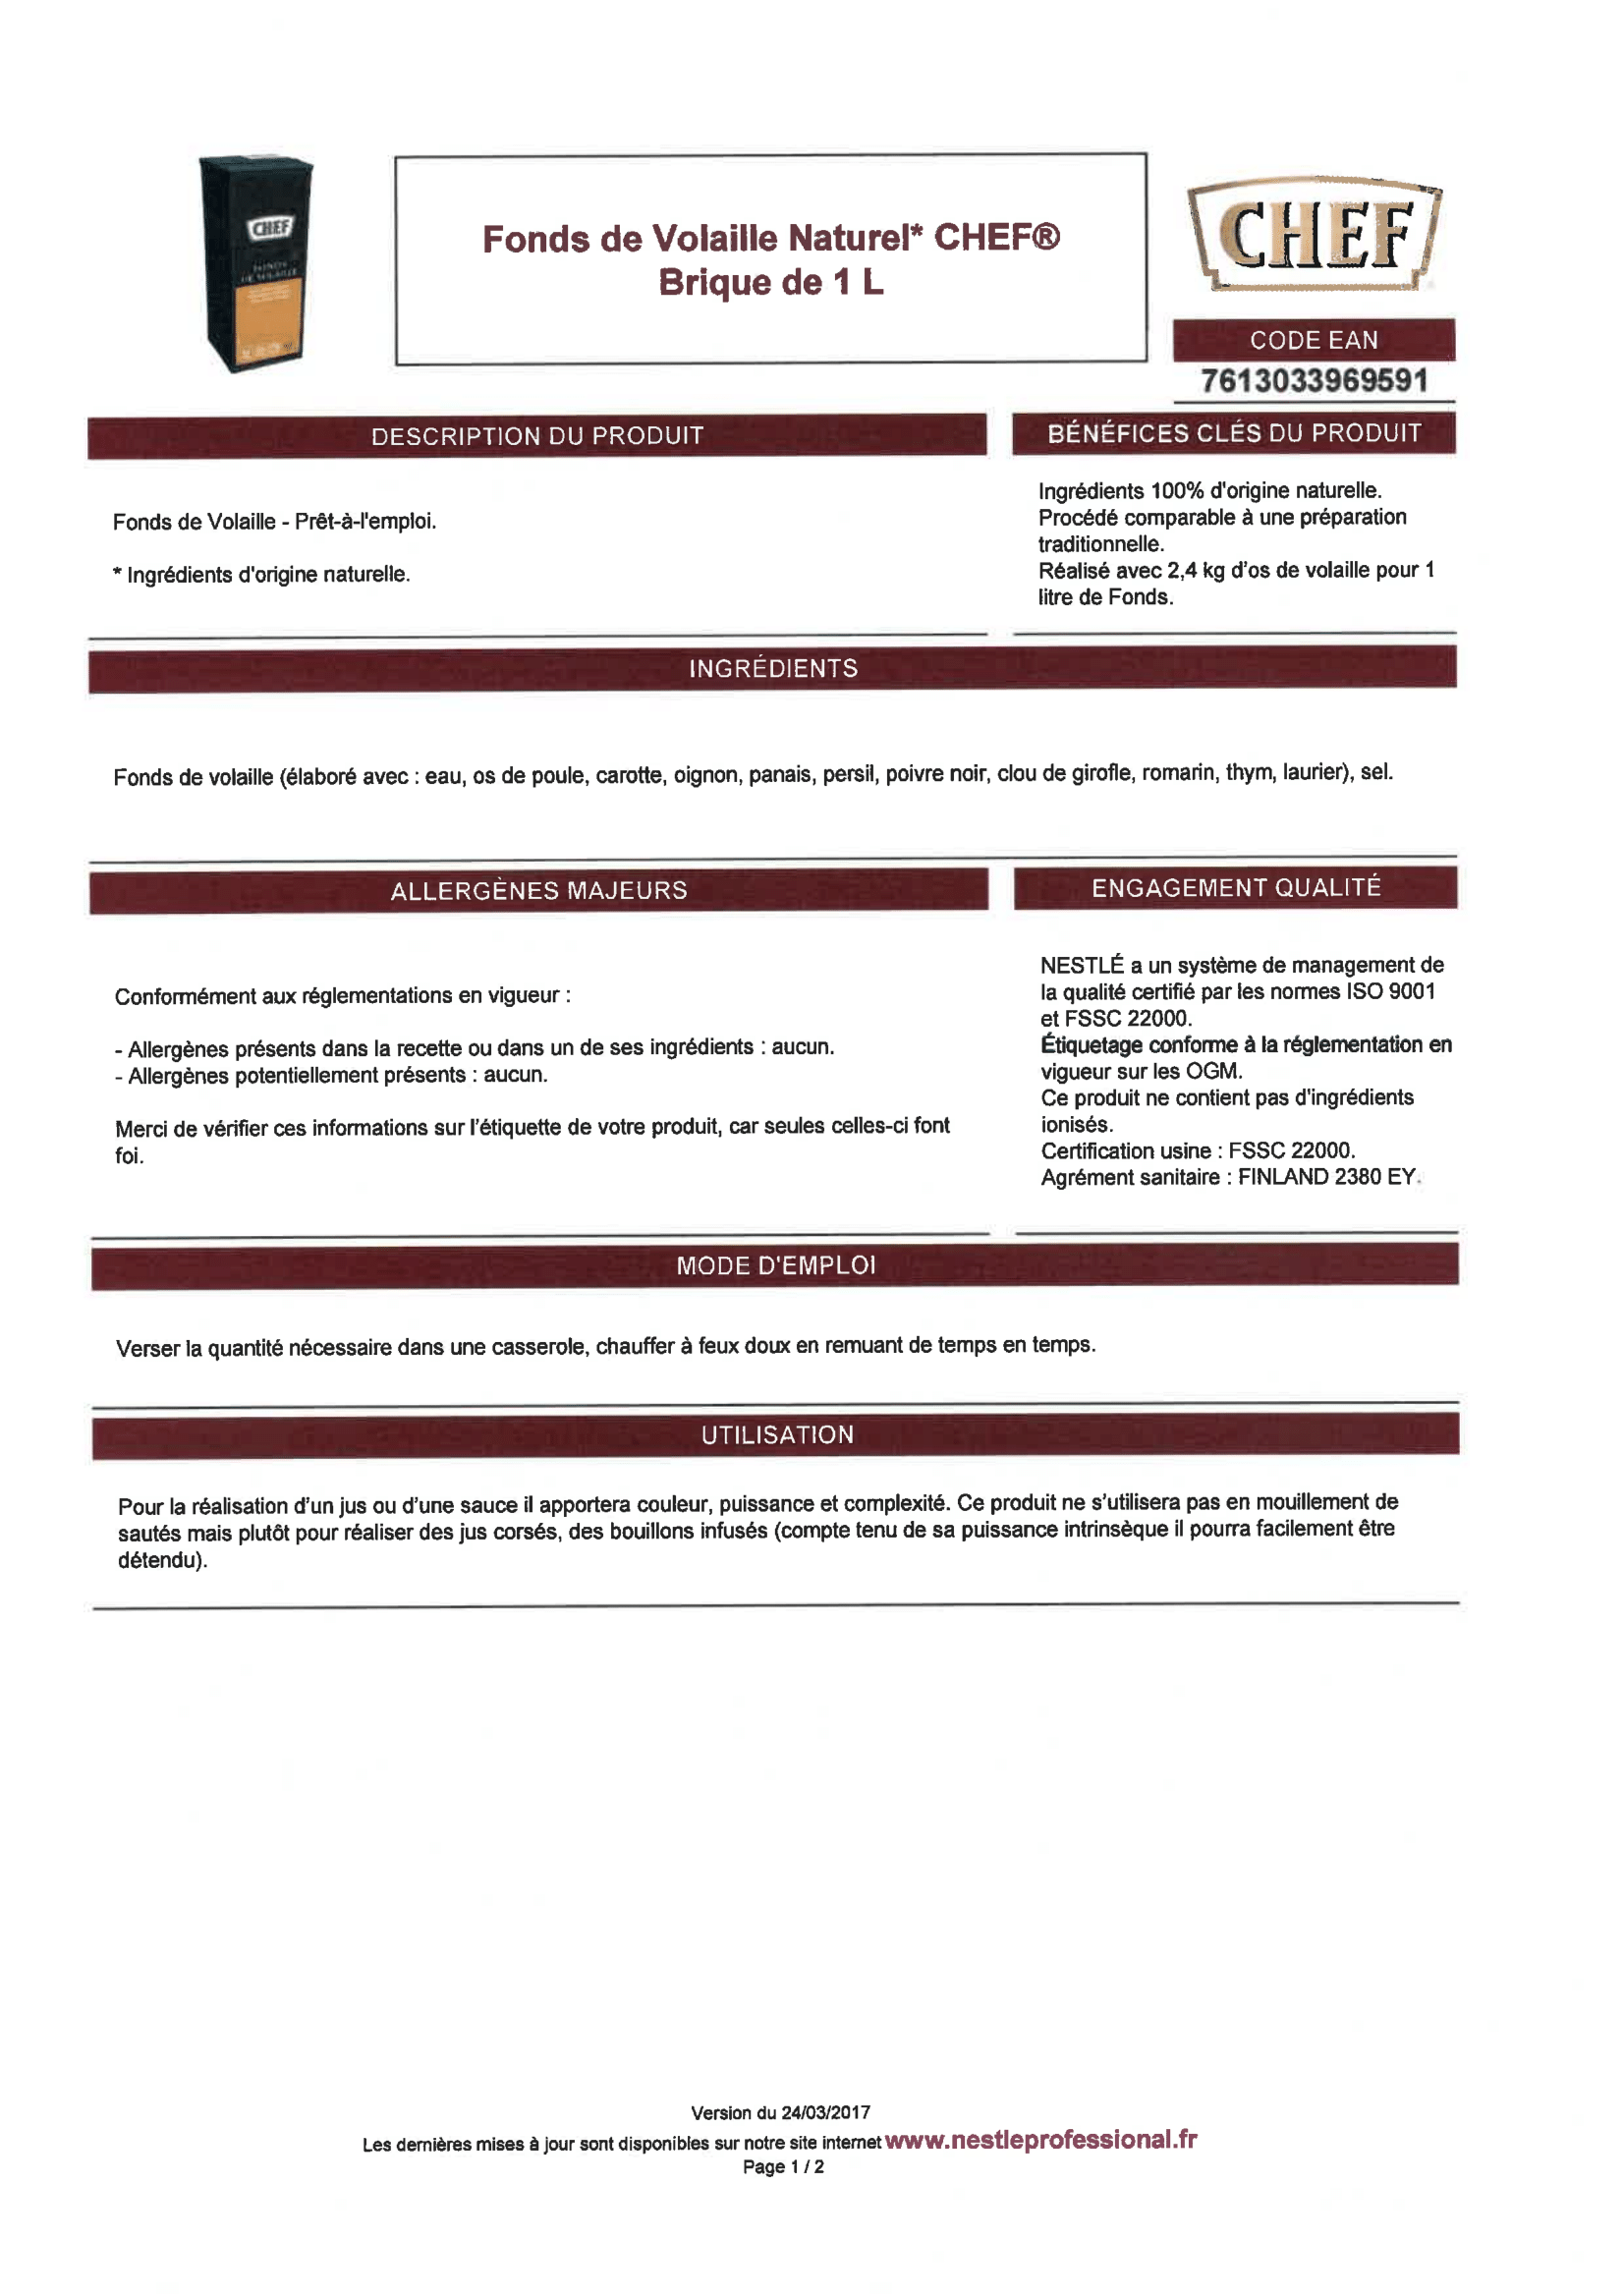

In [5]:
filename = 'FT-91684_Fd volaille nat brq 1L Chef_Nestle-2.png'
path = os.path.join('data', filename)
disp.Image(path)

## pyocr

### Récupération uniquement du texte

In [6]:
txt = pyocr.get_available_tools()[0].image_to_string(
    Image.open(path),
    lang='fra',
    builder=pyocr.builders.TextBuilder()
)

print(txt)

œ Fonds de Volaille Naturel* CHEF®
Brique de 1 L

 

 

 

CODE EAN

7613033969591

DESCRIPTION DU PRODUIT CANTON No Tel 1tInE

Ingrédients 100% d'origine naturelle.

 

 

Fonds de Volaille - Prêt-à-l'emploi. Procédé comparable à une préparation
traditionnelle.

* Ingrédients d'origine naturelle. Réalisé avec 2,4 kg d'os de volaille pour 1
litre de Fonds.

 

 

Fonds de volaille (élaboré avec : eau, os de poule, carotte, oignon, panais, persil, poivre noir, clou de girofle, romarin, thym, laurier), sel.

 

ALLERGÈNES MAJEURS ENGAGEMENT QUALITÉ

NESTLÉ a un système de management de

 

Conformément aux réglementations en vigueur : la qualité certifié par les normes ISO 9001
et FSSC 22000.
- Allergènes présents dans la recette ou dans un de ses ingrédients : aucun. Étiquetage conforme à la réglementation en
- Allergènes potentiellement présents : aucun. vigueur sur les OGM.
Ce produit ne contient pas d'ingrédients
Merci de vérifier ces informations sur l'étiquette de votre produit, ca

### Utilisation des WordBox

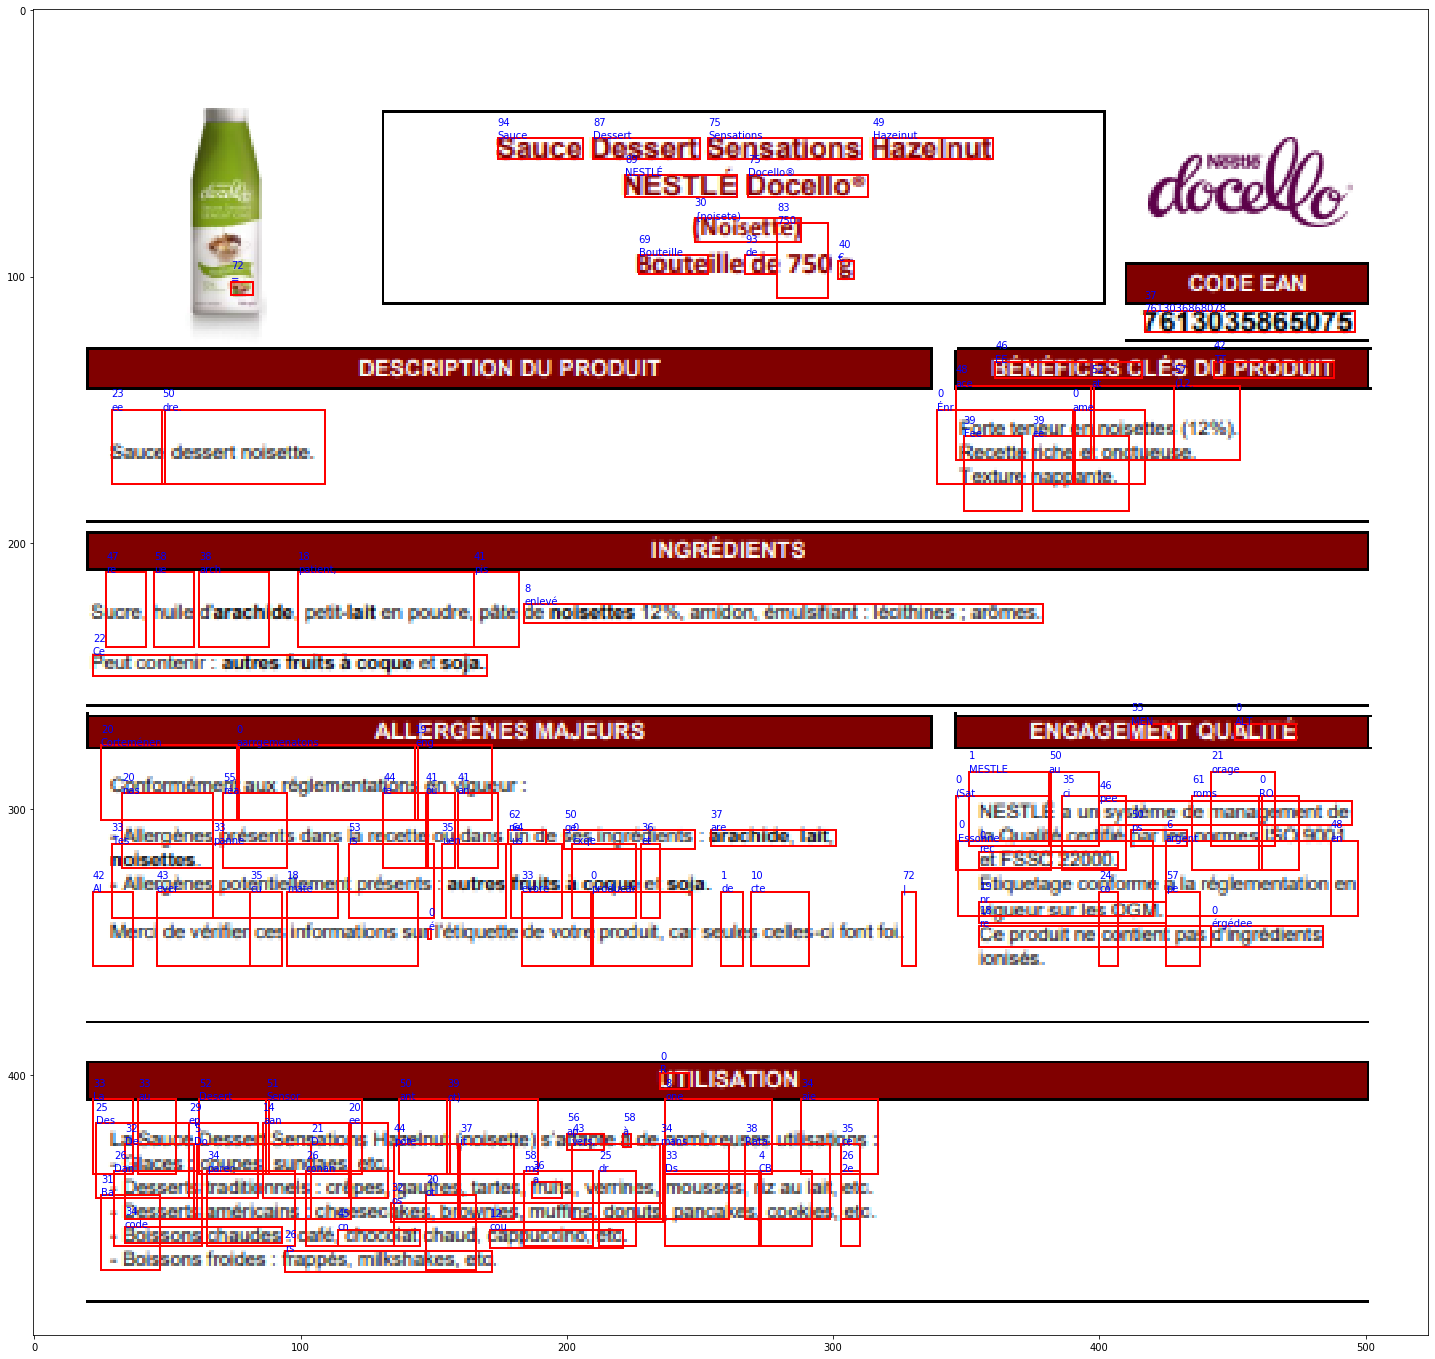

In [7]:
boxes = pyocr.get_available_tools()[0].image_to_string(
    Image.open(os.path.join('data', files[2])),
    lang='fra',
    builder=pyocr.builders.WordBoxBuilder(tesseract_layout=12)
)

fig, imgplot = plt.subplots(figsize=(25, 25))
img = mpimg.imread(os.path.join('data', files[2]))
imgplot.imshow(img)

for box in boxes:
    #if box.content.strip() != '':
        imgplot.add_patch(mpatch.Rectangle(*to_rect_coord(box.position), fill=False, color='red', lw=2))
        imgplot.annotate(str(round(box.confidence)), (box.position[0][0], box.position[0][1] - 5), color='blue')
        imgplot.annotate(box.content, box.position[0], color='blue')

Mise en évidence des boites qui sont vides :

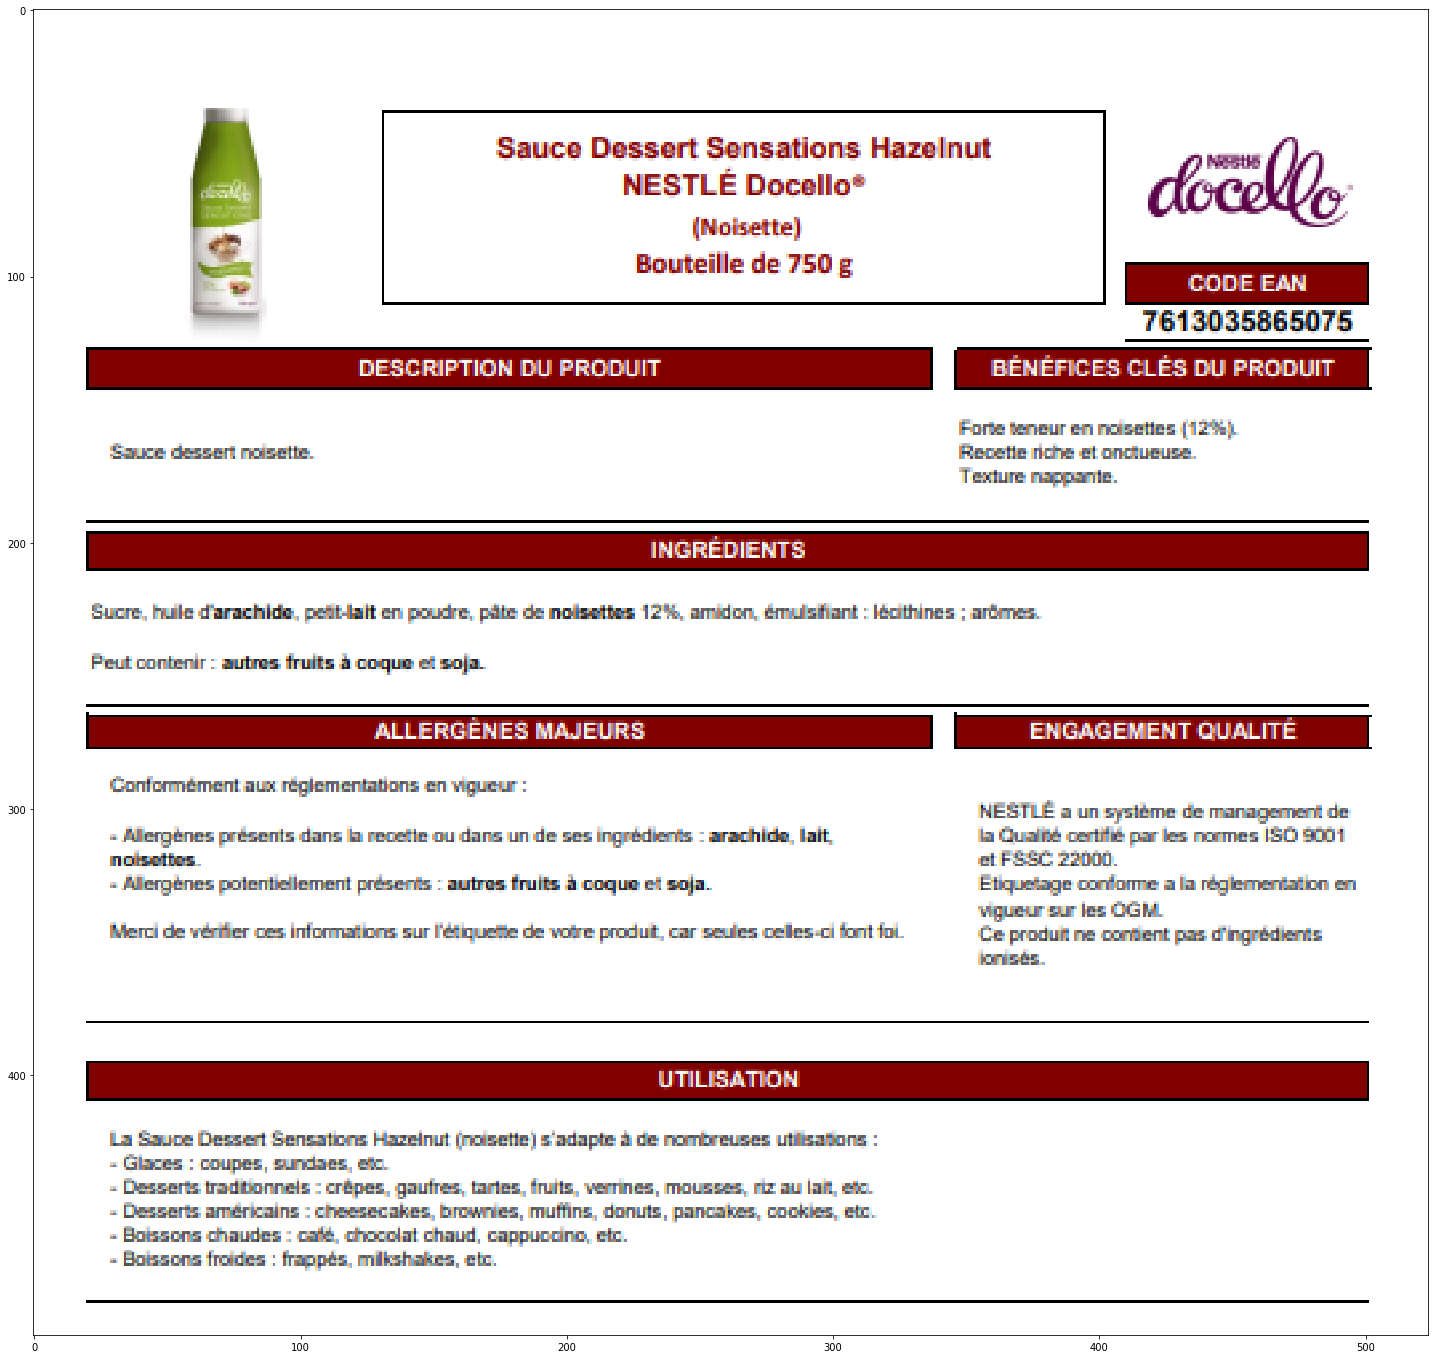

In [8]:
fig, imgplot = plt.subplots(figsize=(25, 25))
imgplot.imshow(img)

for box in boxes:
    if box.content.strip() == '': 
        imgplot.add_patch(mpatch.Rectangle(*to_rect_coord(box.position), fill=False, color='red', lw=2))

pass

### Utilisation des LineBox

In [11]:
tool = pyocr.get_available_tools()[1]
boxes = tool.image_to_string(
    Image.open(path),
    lang='fra',
    builder=pyocr.builders.LineBoxBuilder()
)

print(boxes[0].content)
print(boxes[0].position)

œ Fonds de Volaille Naturel* CHEF®
((253, 220), (1079, 257))


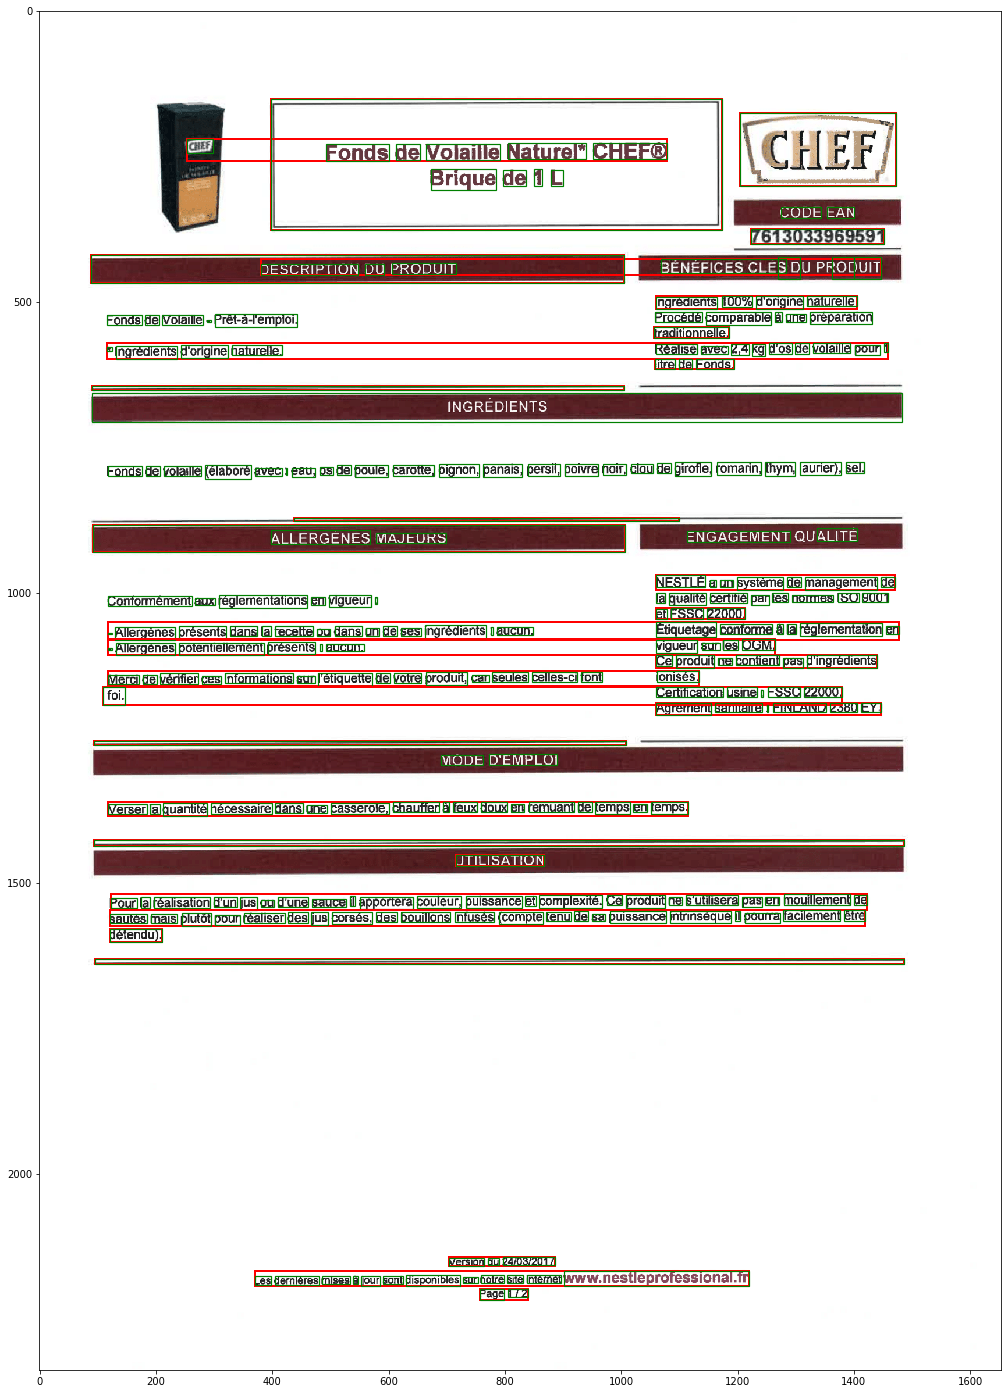

In [12]:
fig, imgplot = plt.subplots(figsize=(25, 25))
img = mpimg.imread(path)
imgplot.imshow(img)

for box in boxes:
    if box.content.strip() != '':
        #print('line: ' + str(box.position) + '|' + box.content.strip())
        imgplot.add_patch(mpatch.Rectangle(*to_rect_coord(box.position), fill=False, color='red', lw=2))
        for subbox in box.word_boxes:
            #print('word: ' + str(subbox.position) + '|' + subbox.content)
            imgplot.add_patch(mpatch.Rectangle(*to_rect_coord(subbox.position), fill=False, color='green', lw=1.2))


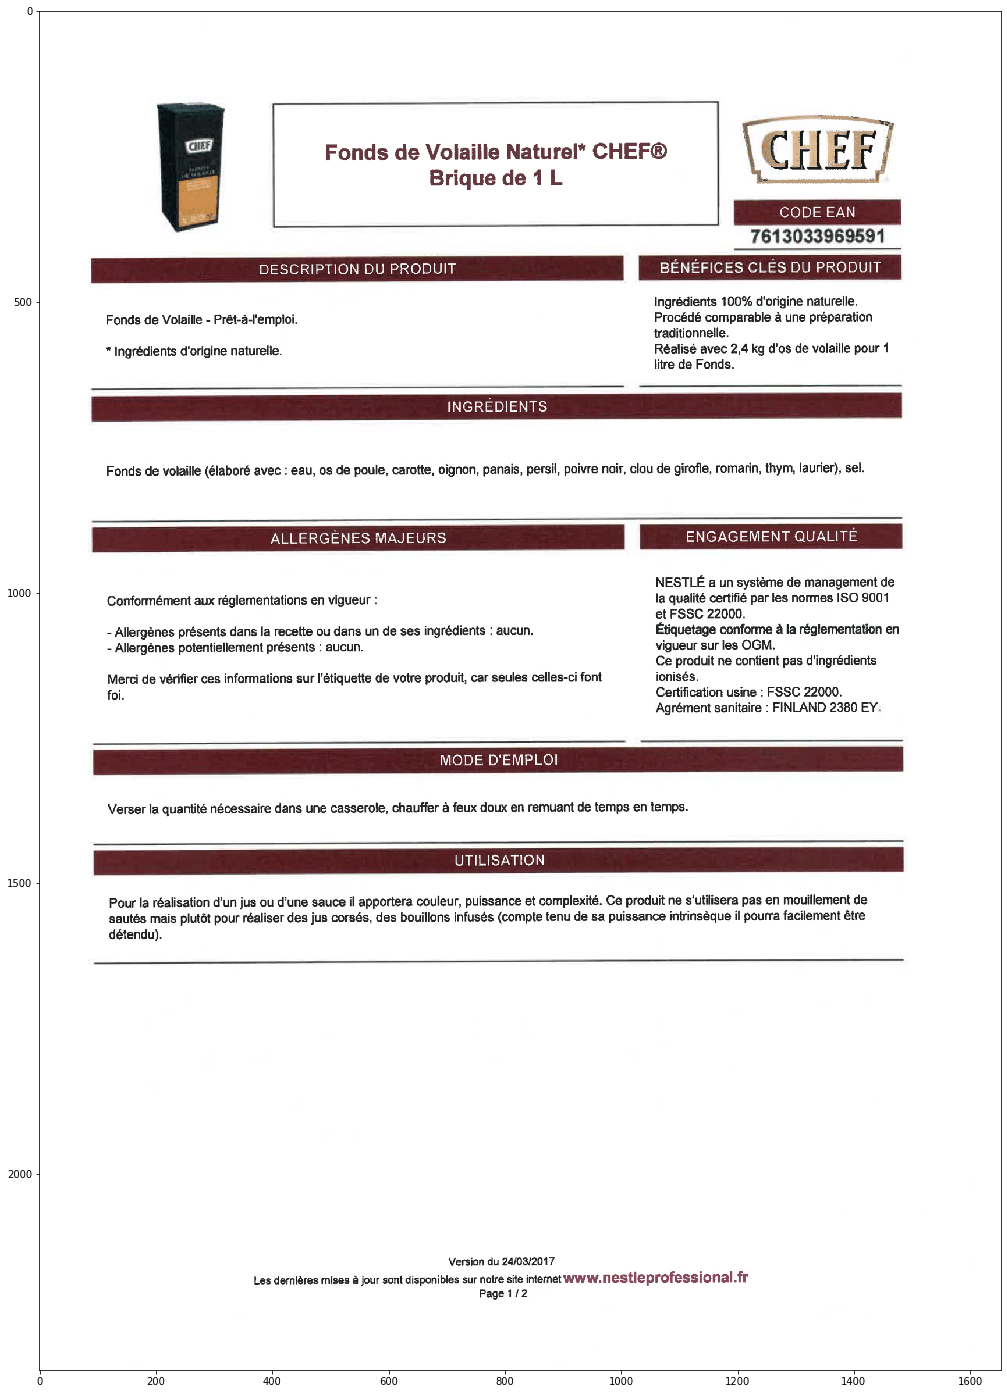

In [13]:
fig, imgplot = plt.subplots(figsize=(25, 25))
img = mpimg.imread(path)
imgplot.imshow(img)

for box in boxes:
    #print(str(box[0]) + ': ' + box[1].content) 
    if box.content.strip() == '':
        imgplot.add_patch(mpatch.Rectangle(*to_rect_coord(box.position), fill=False, color='red', lw=2))

pass

## Comparatif de ces solutions

On construit un outil qui permet de comparer la performance de chacun des outils.

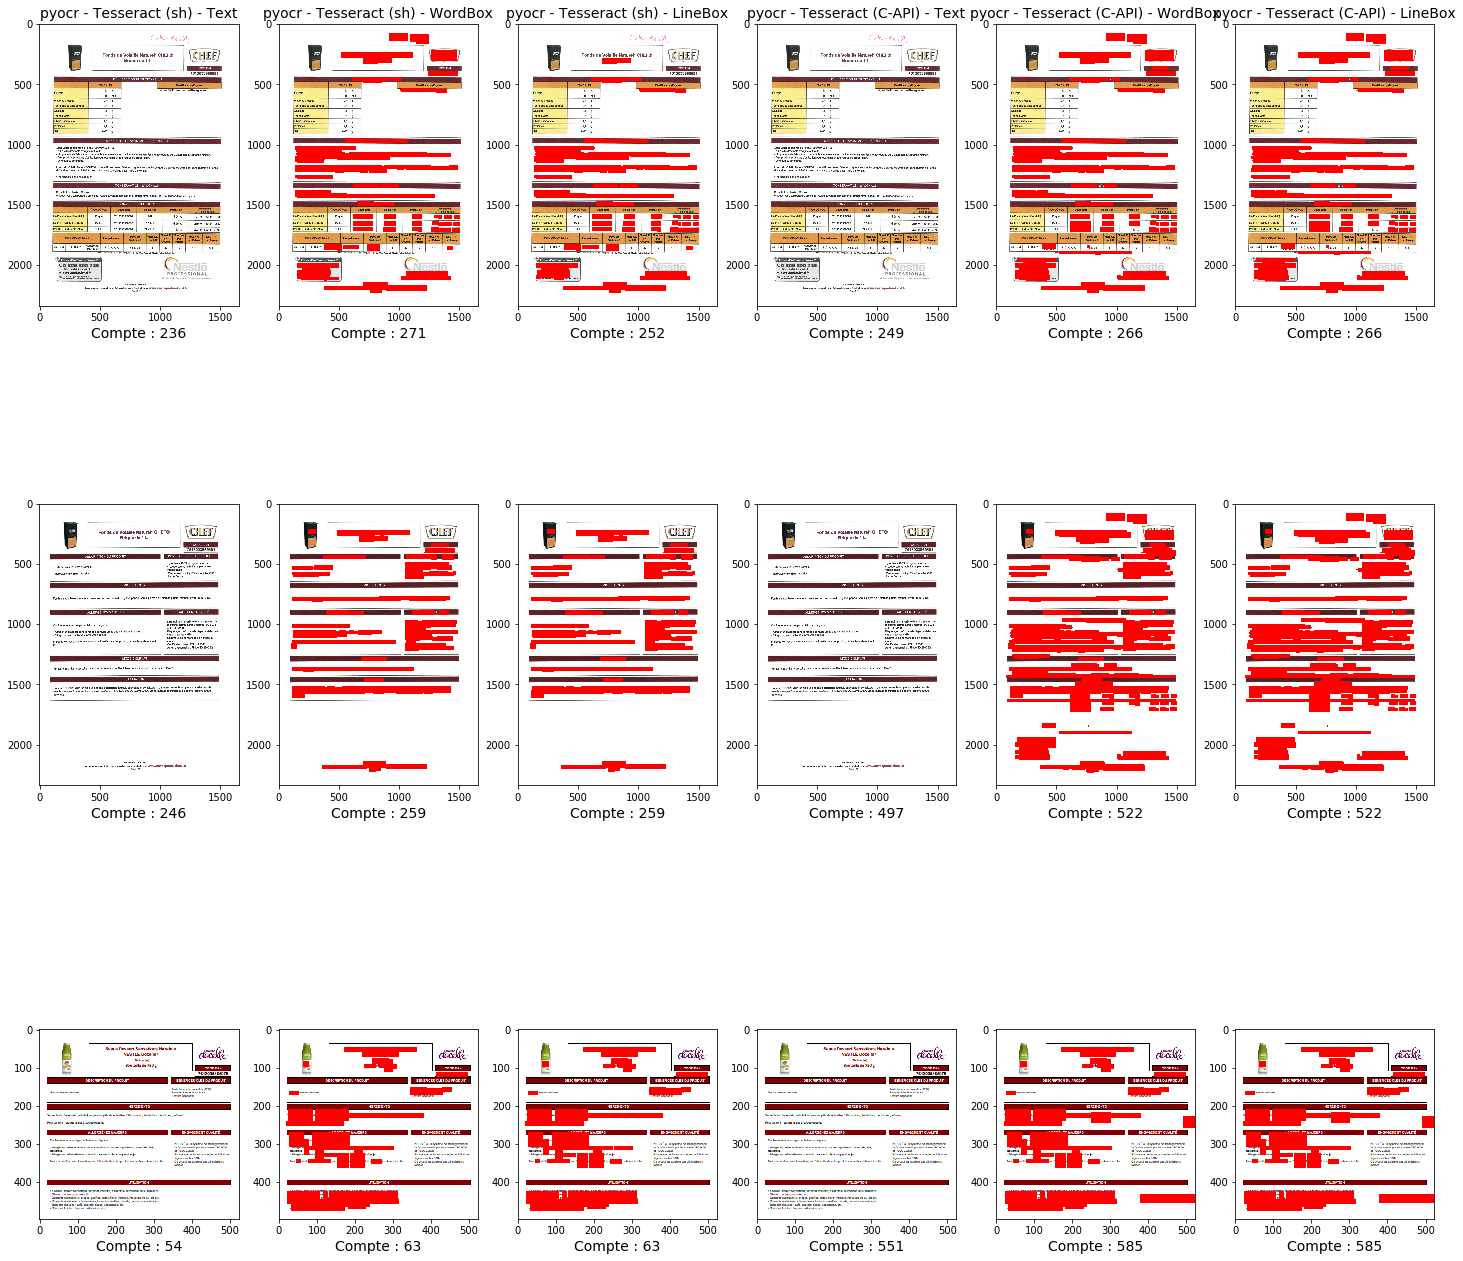

In [14]:
fig, axs = plt.subplots(nrows=len(files), ncols=len(tools), squeeze=False, figsize=(25, 25))
for cpt, tool_def in enumerate(tools):
    axs[0][cpt].set_title(tool_def['name'], fontsize=14)

for cpt, file in enumerate(files):
    path = os.path.join('data', file)
    img = mpimg.imread(path)
    for cpt2, tool_def in enumerate(tools):
        ax = axs[cpt, cpt2]
        ax.imshow(img)
        # getting the tool results
        if tool_def['wrapper'] == 'pyocr':
            tool = pyocr.get_available_tools()[tool_def['tool_order']]
            tool_result = tool.image_to_string(Image.open(path),
                                               lang='fra',
                                               builder=tool_def['builder']
                                              )
        # counting the results
        word_count = 'n/a'
        if tool_def['wrapper'] == 'pyocr':
            if tool_def['kind'] == 'text':
                word_count = len(tool_result.split())
            if tool_def['kind'] == 'wordbox':
                word_count = len(tool_result)
            if tool_def['kind'] == 'linebox':
                word_count = sum([len(line.word_boxes) for line in tool_result])
        axs[cpt, cpt2].set_xlabel('Compte : ' + str(word_count), fontsize=14)
        
        # highlighting the results
        if tool_def['wrapper'] == 'pyocr':
            if tool_def['kind'] == 'wordbox':
                for box in tool_result:
                    if box.content.strip() != '':
                        ax.add_patch(mpatch.Rectangle(*to_rect_coord(box.position), fill=True, color='red', lw=2))              
            if tool_def['kind'] == 'linebox':
                for box in tool_result:
                    if box.content.strip() != '':
                        for subbox in box.word_boxes:
                            if subbox.content.strip() != '':
                                ax.add_patch(mpatch.Rectangle(*to_rect_coord(subbox.position), fill=True, color='red', lw=2))
            
